In [1]:
import torch
import numpy as np
from hysteresis.base import BaseHysteresis
from hysteresis.training import train_hysteresis
from hysteresis.visualization import plot_hysterion_density
import matplotlib.pyplot as plt

In [2]:
def get_data(fname):

    data = []
    with open(fname,'r') as f:
        f.readline()
        for line in f:
            temp = line.rstrip().split(' ')
            d = []
            for ele in temp:
                if ele != '':
                    d += [ele]
            data += [d]
    data = np.asfarray(data)
    return data

(187, 9)


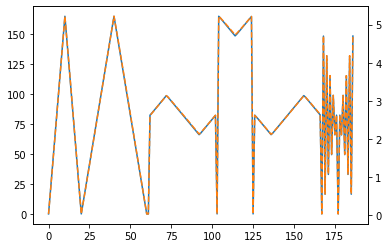

In [3]:
full_data = []
for ele in range(3,9):
    fname = f'D:/SLAC/hysteresis/magnet_characterization/2Q10_4194/strplt.ru{ele}'
    full_data += [get_data(fname)]
full_data = np.vstack(full_data)
print(full_data.shape)

# get real h, m
h = torch.tensor(full_data[:,1]).double()
m = torch.tensor(full_data[:,3]).double()

n_train = 103
h_train = h[:n_train]
m_train = m[:n_train]

fig, ax  = plt.subplots()
ax.plot(h)
axb = ax.twinx()
axb.plot(m,'--C1')

tensor(5.2181, dtype=torch.float64)


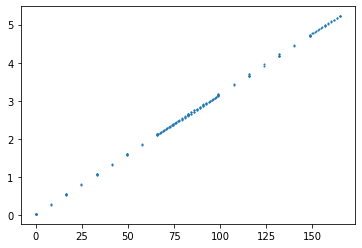

In [16]:
fig,ax = plt.subplots()
ax.plot(h, m,'o',ms=1)
print(max(m))

0
111
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


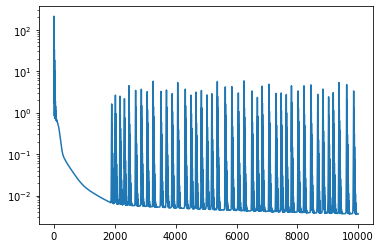

In [5]:
# fit using normal hysteresis model
H = BaseHysteresis(
    h_train,
    m_train,
    mesh_scale = 1.0,
    fixed_domain=torch.tensor((torch.min(h), torch.max(h)))
)
print(len(H.mesh_points))
# train on data
loss_trace = train_hysteresis(
    H,
    10000,
    lr=0.01,
    atol=1e-8,
)
fig, ax = plt.subplots()
ax.semilogy(loss_trace)

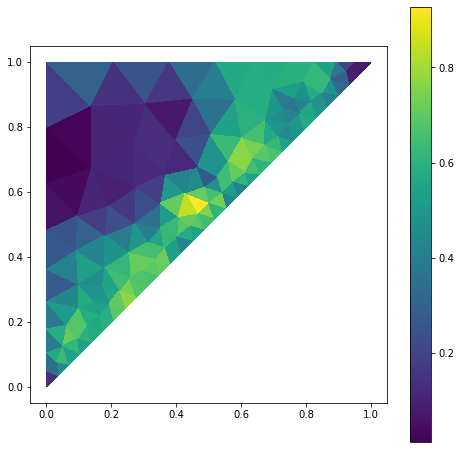

In [6]:
fig,ax,c = plot_hysterion_density(H)
ax.set_aspect('equal')
fig.set_size_inches(8,8)

In [7]:
for name, val in H.named_parameters():
    print(f'{name}:{val}')

raw_hysterion_density:Parameter containing:
tensor([-1.7436, -2.2139,  0.0156, -1.4653, -0.3752, -0.1405, -0.0126,  0.2567,
         1.1030,  1.2628,  1.1021,  0.4179,  0.5989,  1.2594, -1.8665, -0.5441,
         0.5815, -0.1106, -0.3651, -3.0622,  0.0418, -0.0862,  0.0517,  1.2339,
        -0.1151, -0.0454,  0.8560, -0.6177, -1.2046, -1.9533, -3.5168, -2.2139,
        -0.4089,  0.4268,  0.0930,  0.3735,  0.2876, -0.6894, -0.5417, -5.0634,
        -5.9998, -2.3668, -1.9217, -1.6386, -1.0967, -1.4443, -2.2878,  3.0221,
         1.2101,  0.5778,  0.7498,  0.9365, -0.0205,  0.8441,  0.1935, -3.4248,
        -2.2906,  0.2815, -0.1982,  0.6535,  0.4300,  0.1285, -0.1118, -1.1617,
         0.4275,  1.0546, -3.0783, -2.3995, -0.2830, -1.3825, -2.6353,  0.1674,
         0.3799,  0.5864,  1.1043,  0.9054, -1.2082, -1.2791,  5.5018, -1.0532,
        -0.2943, -1.9498,  1.1107,  1.5912,  1.6204, -0.5148,  0.6212,  0.0545,
         0.7260,  1.5187,  1.6273,  0.3764,  0.7715, -0.3537, -0.1549,  1.30

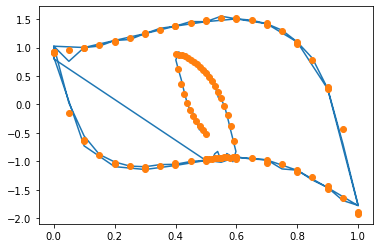

In [8]:
# plot regression
fig, ax = plt.subplots()
m_pred = H(h_train)
th, tm = H.transformer.transform(h_train, m_train)

ax.plot(th, m_pred.detach())
ax.plot(th, tm,'o')


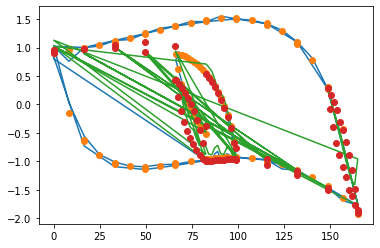

In [9]:
# plot prediction
fig2, ax2 = plt.subplots()
fig.set_size_inches(10,10)

H.regression()
m_regression = H(h)
th, tm = H.transformer.transform(h, m)

ax2.plot(h[:n_train], m_regression[:n_train].detach())
ax2.plot(h[:n_train], tm[:n_train],'o')

# plot future points
ax2.plot(h[n_train:], m_regression[n_train:].detach())
ax2.plot(h[n_train:], tm[n_train:],'o')


train RMS percentage error 1.753337789300857
test RMS percentage error 5.570362697000923


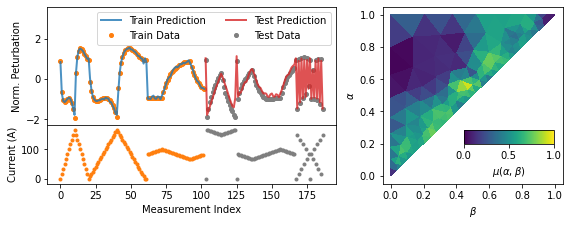

In [15]:
gridspec_kw = dict(height_ratios=[2,1], hspace=0.0,width_ratios=[2,1.25],right=0.97,
                   top=0.97,bottom=0.15,left=0.075)
fig2 = plt.figure()
spec = fig2.add_gridspec(2,2, **gridspec_kw)

ax2 = fig2.add_subplot(spec[0,0])
ax3 = fig2.add_subplot(spec[1,0])
ax4 = fig2.add_subplot(spec[:,1])

fig2.set_size_inches(8,3)
ms=4
lw=2
alpha=0.8

idx = torch.arange(len(tm))
ax2.plot(idx[:n_train], m_regression[:n_train].detach(), label='Train Prediction',
         zorder=10, lw=lw,alpha=alpha)
ax2.plot(idx[:n_train], tm[:n_train],'o',ms=ms, label='Train Data')

# plot future points
ax2.plot(idx[n_train:], m_regression[n_train:].detach(), label='Test Prediction',
         zorder=10, c='C3',lw=lw,alpha=alpha)
ax2.plot(idx[n_train:], tm[n_train:],'o',ms=ms, label='Test Data',c='C7')
ax2.set_ylabel('Norm. Peturbation')
w =  max(tm) - min(tm)
ax2.set_ylim(min(tm) - 0.1*w, max(tm) + 0.6*w)
ax2.legend(ncol=2)#loc=2)
frac_error = 100.0*(tm - m_regression) / (torch.max(tm)-torch.min(tm))
print(f'train RMS percentage error {torch.std(frac_error[:n_train])}')
print(f'test RMS percentage error {torch.std(frac_error[n_train-1:])}')

ax3.plot(idx[n_train:], h[n_train:],'.C7')
ax3.plot(idx[:n_train-1], h[:n_train-1],'.C1')
ax3.set_ylabel('Current (A)')
w = max(h) - min(h)
ax3.set_ylim(min(h) - 0.1*w, max(h) + 0.1*w)
ax3.set_xlabel('Measurement Index')

_, _, c = plot_hysterion_density(H,ax=ax4)
c.set_clim(0,1)
# embed colorbar inside plot
box = ax4.get_position()
width = box.width
height = box.width
rect = [0.45,0.225,0.5,0.2]
inax_position  = ax4.transAxes.transform(rect[0:2])
transFigure = fig2.transFigure.inverted()
infig_position = transFigure.transform(inax_position)
x = infig_position[0]
y = infig_position[1]
width *= rect[2]
height *= rect[3]
new_rect= [x,y,width,height]
cax = fig2.add_axes(new_rect)

cax = fig2.colorbar(c, cax=cax, orientation='horizontal')
ax4.set_ylabel(r'$\alpha$')
ax4.set_xlabel(r'$\beta$')
cax.set_label(r'$\mu(\alpha,\beta)$')
cax.set_ticks((0,0.5,1))
#fig2.tight_layout()
fig2.savefig(f'slac_training{n_train}.png', dpi=300)

In [11]:
# compare linear fitting error to hysteresis model error
m_regression_real = H(h, return_real=True)
m_error = (m_regression_real - m)
print(torch.std(m_error[n_train:]))
print(torch.std(m_error[:n_train]))


# fit data with polynomial
h_np = h.flatten().numpy()
m_np = m.flatten().detach().numpy()
z = np.polyfit(h_np, m_np, 4)
m_poly_error = (np.poly1d(z)(h_np) - m_np)
print(np.std(m_poly_error))


tensor(0.0029, dtype=torch.float64, grad_fn=<StdBackward0>)
tensor(0.0009, dtype=torch.float64, grad_fn=<StdBackward0>)
0.012137933704974511


In [12]:
##Notes
# n_train train_error(mT) test_error(mT)
# 103 0.7 2.2
# 62 0.8 2.6
# 187 1.3 N/A
# 103 (low res) 0.9 2.9